In [124]:
# Instructions for submission

# 1. Rename this file to groupXX_PPGHR.ipynb where XX is your group number as visible in the Google spreadsheet
# 2. State the team members (e-mail, legi):
# example@student.ethz.ch, XX-YYY-ZZZ
# JOE MAMA
# FAT ASS
# TO BE FILLED
# 3. Kaggle team name: TO BE FILLED
# 4. Upload this file in a zipped folder together with your final predictions to the provided Polybox link. See the Submission section in the PDF for more details.

In [1]:
# Import necessary libraries
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sktime.regression.deep_learning.resnet import ResNetRegressor
from sktime.regression.deep_learning.cnn import CNNRegressor
from sktime.regression.deep_learning.mcdcnn import MCDCNNRegressor
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


In [2]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def passband_heart(ppg_signal, fs):
    # Bandpass filter to isolate heart rate component
    # : highcut to 160bpm = 2.67Hz
    lowcut = 0.67 / (0.5 * fs)  # 40 bpm
    highcut = 2.67 / (0.5 * fs)  # 240 bpm
    b, a = butter(1, [lowcut, highcut], btype='band')
    filtered_signal = lfilter(b, a, ppg_signal)
    return filtered_signal

def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

In [39]:
def prepare_data(phase,y):
    INTERVAL_LENGTH = 128*30
    X = []
    for i in range(len(y)):
        X.append(phase[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH])
    return np.array(X)

def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def create_dataloaders_from_arrays(X_train, y_train, X_test, y_test, batch_size=16):
    # Convert arrays to PyTorch tensors
    X_train_torch = torch.tensor(X_train)
    y_train_torch = torch.tensor(y_train)
    X_test_torch = torch.tensor(X_test)
    y_test_torch = torch.tensor(y_test)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_torch, y_train_torch)
    test_dataset = TensorDataset(X_test_torch, y_test_torch)

    # Create DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define the loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    return model

def test_model(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))
    
def predict(model, data):
    # Convert the data to a PyTorch tensor and add an extra dimension
    data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_tensor = data_tensor.to(device)
    model = model.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make the prediction
    with torch.no_grad():
        output = model(data_tensor)

    # Convert the output tensor to a numpy array and return it
    return output.cpu().numpy()


In [4]:
sampling_rate = 128  # Hz

# Load data item containing the PPG, HR, and IMU signals from all phases
data = np.load('mhealth24_data_public.npy', allow_pickle=True).item() # now it is a dict

print('Keys for data:', data.keys())

# Example to extract the data from phase 0
# phase 0,3: wrist
# testing: phases 1,3,5
phase0_data = data['phase 0']
print('Keys for phase 0:', phase0_data.keys())

# Get the individual signals from phase 0
ppg_phase0 = phase0_data['PPG wrist']
ref_hr_phase0 = phase0_data['ground truth HR']  # only available for phase 0, 2, and 4 (training data)
IMU_X_phase0 = phase0_data['IMU X wrist']
IMU_Y_phase0 = phase0_data['IMU Y wrist']
IMU_Z_phase0 = phase0_data['IMU Z wrist']

Keys for data: dict_keys(['phase 0', 'phase 1', 'phase 2', 'phase 3', 'phase 4', 'phase 5'])
Keys for phase 0: dict_keys(['ground truth HR', 'PPG wrist', 'IMU X wrist', 'IMU Y wrist', 'IMU Z wrist'])


In [40]:
y = ref_hr_phase0
sig_flt = passband_heart(ppg_phase0, sampling_rate)
X = prepare_data(sig_flt,y)
X = normalize_data(X)
X_train, X_test, y_train, y_test = split_data(X, y)

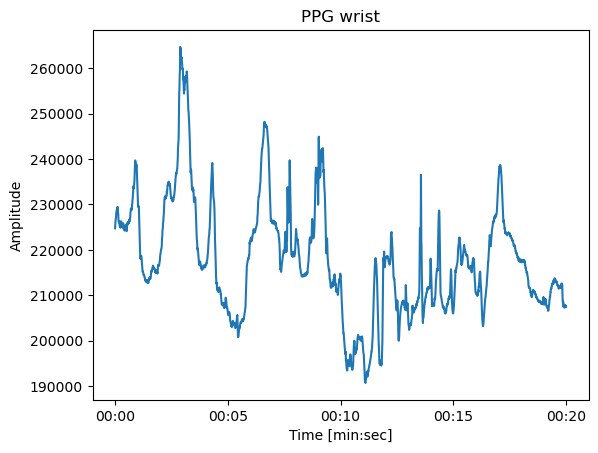

In [6]:
# Function to plot any signal with time on the x-axis
def plot_signal(signal, title, ylabel, sampling_rate=128):
    x = np.linspace(0, len(signal) / sampling_rate, len(signal))
    t = pd.to_datetime(x, unit='s')

    fig, ax = plt.subplots()
    ax.plot(t, signal)
    ax.set_title(title)
    ax.set_xlabel('Time [min:sec]')
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    plt.show()

# If you want to be able to interactively look at your plotted data (e.g., zooming in or out),
# uncomment the line with "%matplotlib widget" below
# Careful: This does not work on Kaggle, but requires that you run the Jupyter Notebook locally on your computer
# If you have an interactive plot and you want to go back to the non-interactive plot, comment the line with 
# "%matplotlib widget" out and restart your kernel
# If you accidently run this script on Kaggle when "%matplotlib widget" is not commented out and you receive an error afterwards that your plot cannot be plotted, comment "%matplotlib widget" out and restart the kernel via "Run << Factory reset"

# %matplotlib widget

# Example plot of a 10-second window of the PPG signal
plot_window_start = 120  # in seconds
plot_window_end = 140  # in seconds
plot_signal(ppg_phase0[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG wrist', 'Amplitude')

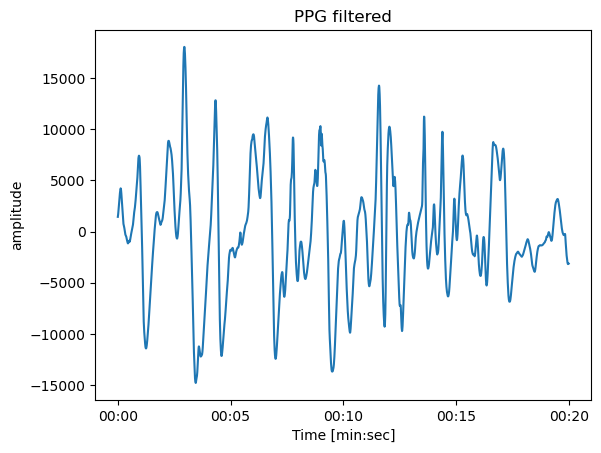

In [7]:
plot_signal(sig_flt[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG filtered', 'amplitude', sampling_rate)


In [8]:
# Function to print the mean and median absolute error between your predicted HR and the reference HR
# With this function, you can evaluate the resulting score that you would obtain on the public dataset
# with your predicted HR values on Kaggle
def print_score(pred_hr, ref_hr):
    err = np.abs(np.asarray(pred_hr) - np.asarray(ref_hr))
    print("Mean error: {:4.3f}, Median error {:4.3f}".format(np.mean(err), np.median(err)))
    print("Resulting score {:4.3f}".format(0.5 * np.mean(err) + 0.5 * np.median(err)))

# Example on how to use the print_score function with randomly generated HR values as the predictions
pred_hr_phase0 = list(np.random.randint(40, 180, len(ref_hr_phase0)))
print_score(pred_hr_phase0, ref_hr_phase0)

Mean error: 42.673, Median error 35.285
Resulting score 38.979


In [9]:
# For each phase, you should now have obtained a list of predicted HR values
# Below, we give an example of how you can produce the submission.csv file from your predicted HR values
# To demonstrate the format of the submission.csv file, we provide an example with randomly generated HR values
# For phase 0, 1, 2, and 3 you should each obtain 396 HR values
# For phase 4 and 5 you should each obtain 57 HR values
# IMPORTANT: You have to replace the following predicted HR values with your predicted HR values!
pred_hr_phase0 = list(np.random.randint(40, 180, 396))
pred_hr_phase1 = list(np.random.randint(40, 180, 396))
pred_hr_phase2 = list(np.random.randint(40, 180, 396))
pred_hr_phase3 = list(np.random.randint(40, 180, 396))
pred_hr_phase4 = list(np.random.randint(40, 180, 57))
pred_hr_phase5 = list(np.random.randint(40, 180, 57))

# You can keep the below code unchanged to produce the submission.csv file
pred_hr_phases = [pred_hr_phase0, pred_hr_phase1, pred_hr_phase2,
                  pred_hr_phase3, pred_hr_phase4, pred_hr_phase5]
ids = []
pred_hr_flattened = []

for phase_counter in range(len(pred_hr_phases)):
    for hr_counter in range(len(pred_hr_phases[phase_counter])):
        pred_hr_flattened.append(pred_hr_phases[phase_counter][hr_counter])
        ids.append(f'phase{phase_counter}_{hr_counter}')

# If you use Kaggle, on the right side in tab "Output", you should now see a file called "submission.csv" after pressing "refresh"
# Download the file and submit it to the competition on Kaggle to obtain a score on the leaderboard for your team
df = pd.DataFrame({'Id': ids, 'Predicted': pred_hr_flattened})
df.to_csv('submission.csv', index=False)

In [134]:
clf = ResNetRegressor(n_epochs=20, batch_size=4) 
clf.fit(X_train, y_train) 
clf.save('resnetRegressor_model')

INFO:tensorflow:Assets written to: resnetRegressor_model\keras\assets


INFO:tensorflow:Assets written to: resnetRegressor_model\keras\assets


<zipfile.ZipFile filename='resnetRegressor_model.zip' mode='r'>

In [135]:
clf_cnn = CNNRegressor(n_epochs=200, batch_size=4)
clf_cnn.fit(X_train, y_train)
clf_cnn.save('cnnRegressor_model')

INFO:tensorflow:Assets written to: cnnRegressor_model\keras\assets


INFO:tensorflow:Assets written to: cnnRegressor_model\keras\assets


<zipfile.ZipFile filename='cnnRegressor_model.zip' mode='r'>

In [136]:

clf_MCDNCC = MCDCNNRegressor(n_epochs=500, batch_size=16, verbose=True)
clf_MCDNCC.fit(X_train, y_train)
clf_MCDNCC.save('mcdnnRegressor_model')

AssertionError: 

In [139]:
pred = clf_cnn.predict(X_test)

20/20 [==============================] - 0s 4ms/step


In [140]:
print_score(pred, y_test)

Mean error: 6.977, Median error 6.380
Resulting score 6.678


In [15]:
class MyModel(nn.Module):
    #TODO: deeper mode, conv layers, dropout
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc0 = nn.Linear(128*30, 1024)
        self.fc00 = nn.Linear(1024, 1024)
        self.fc1 = nn.Linear(1024, 512)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.25)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 1)
    
    def forward(self, x):
        #x = x.view(x.size(0), -1)
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc00(x))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        self.dropout2(x)
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [31]:
class MyModel2(nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__()
        self.fc0 = nn.Linear(128*30, 1024)
        self.dropout0 = nn.Dropout(p=0.5)
        self.fc00 = nn.Linear(1024, 1024)
        self.dropout00 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(1024, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(128, 32)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = self.dropout0(x)
        x = torch.relu(self.fc00(x))
        x = self.dropout00(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

In [41]:
train_loader, test_loader = create_dataloaders_from_arrays(X_train.astype(np.float32), y_train.astype(np.float32), X_test.astype(np.float32), y_test.astype(np.float32))



In [42]:
model = MyModel()
model2 = MyModel2()
#TODO: increase num_epochs
train_model(model, train_loader, num_epochs=2000, learning_rate=0.001)

c:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/2000], Loss: 855.4088745117188
Epoch [2/2000], Loss: 98.09720611572266
Epoch [3/2000], Loss: 127.99746704101562
Epoch [4/2000], Loss: 53.83555603027344
Epoch [5/2000], Loss: 155.25852966308594
Epoch [6/2000], Loss: 127.48445892333984
Epoch [7/2000], Loss: 95.79623413085938
Epoch [8/2000], Loss: 138.7509002685547
Epoch [9/2000], Loss: 80.46180725097656
Epoch [10/2000], Loss: 121.45133209228516
Epoch [11/2000], Loss: 97.59427642822266
Epoch [12/2000], Loss: 245.41384887695312
Epoch [13/2000], Loss: 83.5330581665039
Epoch [14/2000], Loss: 34.511932373046875
Epoch [15/2000], Loss: 49.738380432128906
Epoch [16/2000], Loss: 150.01055908203125
Epoch [17/2000], Loss: 236.0301055908203
Epoch [18/2000], Loss: 107.83279418945312
Epoch [19/2000], Loss: 240.2035369873047
Epoch [20/2000], Loss: 84.90872192382812
Epoch [21/2000], Loss: 92.89517974853516
Epoch [22/2000], Loss: 136.31430053710938
Epoch [23/2000], Loss: 58.13348388671875
Epoch [24/2000], Loss: 89.9142837524414
Epoch [25/2000], 

MyModel(
  (fc0): Linear(in_features=3840, out_features=1024, bias=True)
  (fc00): Linear(in_features=1024, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
)

In [43]:
pred = predict(model, X_test.astype(np.float32))

In [44]:
print_score(pred, y_test)

Mean error: 6.649, Median error 5.891
Resulting score 6.270
